In [17]:
# pip install qiskit==0.31.0

In [2]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer
import numpy as np
from qiskit.visualization import plot_histogram

def custom_qft(data_qubits):
    qr_data = QuantumRegister(data_qubits,"qbits")
    qc = QuantumCircuit(qr_data)
    i = data_qubits
    while i>=1:
        n = i - 1
        qc.h(qr_data[n]) 
        for qubit in range(n):
            qc.cp(np.pi/2**(n-qubit), qr_data[qubit], qr_data[n])
        i = i-1
    return qc


def subroutine_add_const(data_qubits, const):
    qc = QuantumCircuit(data_qubits)

    for i in range(data_qubits):
        angle = const*np.pi/(2**i)
        qc.p(angle,i)

    return qc

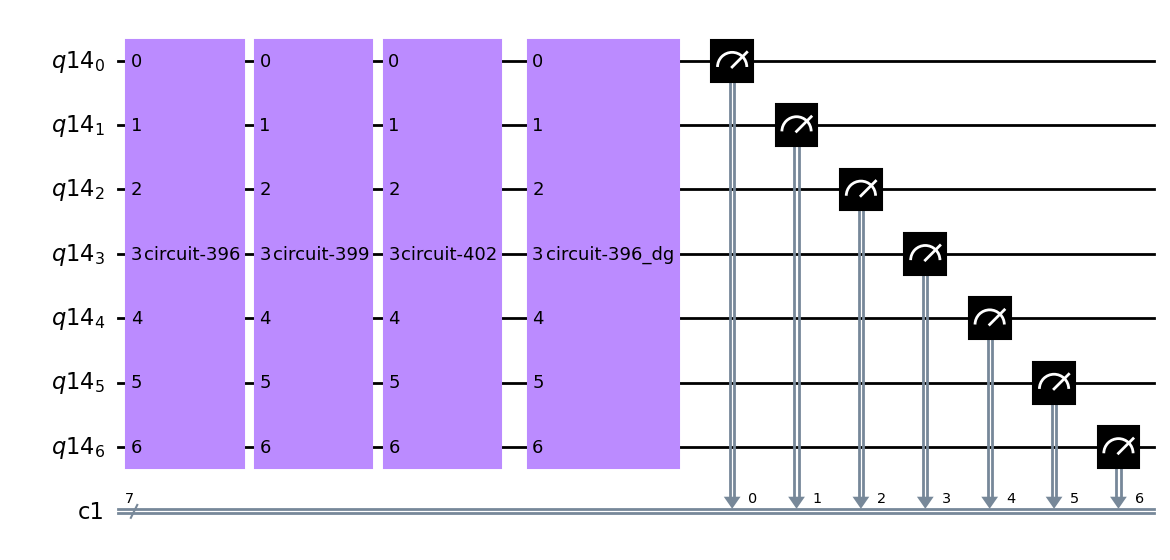

In [5]:
qr = QuantumRegister(7)
cr = ClassicalRegister(7)
qc = QuantumCircuit(qr,cr)


qft_gate = custom_qft(7)

qc.append(qft_gate, qr[:])
qc.append(subroutine_add_const(7,4),qr[:])
qc.append(subroutine_add_const(7,2),qr[:])
qc.append(qft_gate.inverse(), qr[:])


qc.measure(qr,cr)
qc.draw(output='mpl')

In [6]:
from qiskit import BasicAer, execute
backend = BasicAer.get_backend("qasm_simulator")
counts = execute(qc,backend,shots=100).result().get_counts()
counts

{'0000110': 100}

In [11]:
from Circuit_features import *
from Backend_features import *
import qiskit
from qiskit.transpiler import PassManager
from qiskit.converters import circuit_to_dag
from qiskit.transpiler.passes import Unroller
from qiskit.circuit.random import random_circuit
import pandas as pd
import random
import os.path
from qiskit.transpiler.passes import LookaheadSwap, StochasticSwap
from qiskit.transpiler import CouplingMap

In [15]:
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends(simulator=False)
backend = provider.get_backend('ibm_perth')

In [16]:
cmap = IBMQBackend.configuration(backend).to_dict()['coupling_map']

In [17]:
cmap

[[0, 1],
 [1, 0],
 [1, 2],
 [1, 3],
 [2, 1],
 [3, 1],
 [3, 5],
 [4, 5],
 [5, 3],
 [5, 4],
 [5, 6],
 [6, 5]]

In [19]:
backend = provider.get_backend('ibm_nairobi')
cmap = IBMQBackend.configuration(backend).to_dict()['coupling_map']
cmap

[[0, 1],
 [1, 0],
 [1, 2],
 [1, 3],
 [2, 1],
 [3, 1],
 [3, 5],
 [4, 5],
 [5, 3],
 [5, 4],
 [5, 6],
 [6, 5]]